In [35]:
!pip install librosa scikit-learn numpy matplotlib xgboost pandas seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
# -----------------------------
# ✅ IMPORTS AND CPU THREAD CONTROL
# -----------------------------
import os
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["TF_NUM_INTRAOP_THREADS"] = "2"
os.environ["TF_NUM_INTEROP_THREADS"] = "2"

import numpy as np
import librosa
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from tqdm import tqdm
import pandas as pd
import json
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


Total number of audio files (all classes): 16941
Total audio files in classes with > 100 files: 10310

Class counts (above 100):
abhori1 - 126
afpfly1 - 104
barswa - 500
bkctch1 - 109
blakit1 - 262
blbpuf2 - 166
carcha1 - 153
categr - 166
cibwar1 - 113
cohmar1 - 425
colsun2 - 181
combul2 - 293
combuz1 - 477
comsan - 500
eaywag1 - 500
egygoo - 152
eubeat1 - 437
fotdro5 - 137
gargan - 136
gnbcam2 - 239
grecor - 138
greegr - 252
grewoo2 - 103
hadibi1 - 129
hoopoe - 436
laudov1 - 109
litegr - 378
piekin1 - 121
ratcis1 - 172
rbsrob1 - 281
reccuc1 - 122
rerswa1 - 227
rindov - 116
somgre1 - 199
strher - 119
tafpri1 - 161
thrnig1 - 500
varsun2 - 105
wbrcha2 - 132
wlwwar - 500
woosan - 486
yebapa1 - 106
yertin1 - 134
yewgre1 - 108


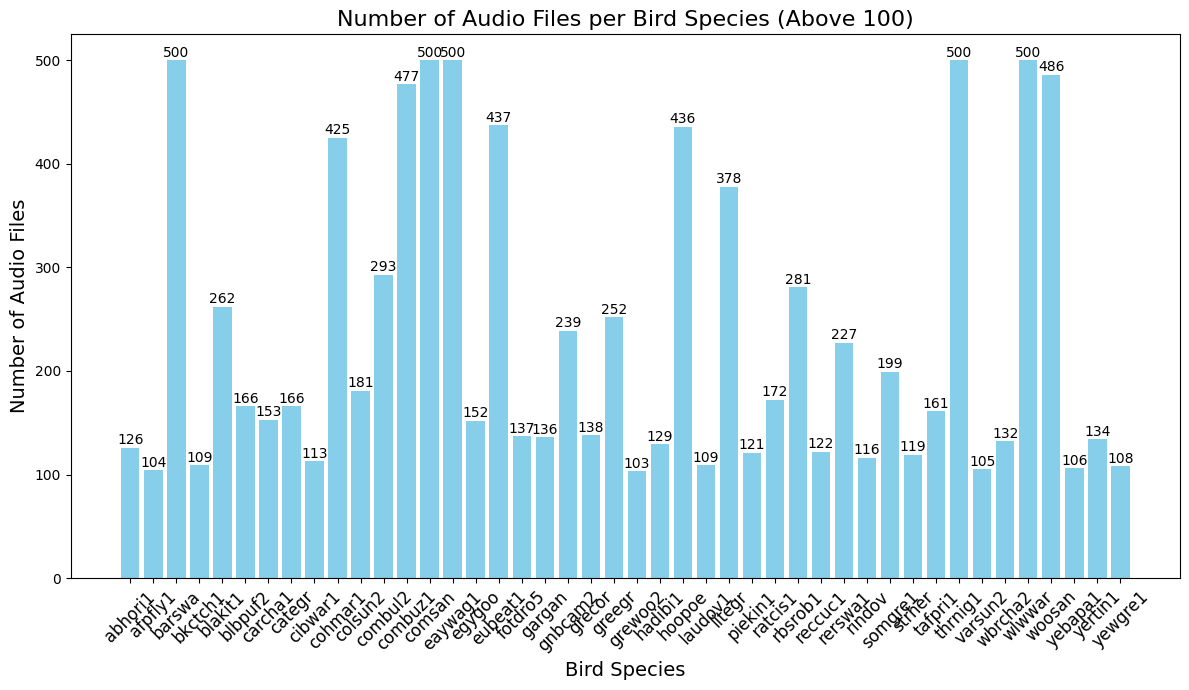

In [37]:
import os
import matplotlib.pyplot as plt

# Define your folder structure
data_dir = "train_audio/"

# Automatically detect class folders
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

# Count the number of files for each class
class_counts = {}
total_files = 0               # Total files across all classes
filtered_total_files = 0      # ✅ Total files for classes where count > 90

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        count = len([
            file for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        ])
        total_files += count  # Total files (all classes)

        if count > 100:        # Condition: only count classes with > 100 files
            class_counts[class_name] = count
            filtered_total_files += count  # ✅ Count only filtered class files

# ✅ Print total number of audio files across all classes
print(f"\nTotal number of audio files (all classes): {total_files}")

# ✅ Print number of audio files for classes with > 100 files
print(f"Total audio files in classes with > 100 files: {filtered_total_files}")

# ✅ Print each class with its count (only those with count > 100)
print("\nClass counts (above 100):")
for class_name, count in class_counts.items():
    print(f"{class_name} - {count}")

# --- Optional: Plotting ---
labels = list(class_counts.keys())
values = list(class_counts.values())

plt.figure(figsize=(12, 7))
bars = plt.bar(labels, values, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{int(yval)}", ha='center', va='bottom', fontsize=10, color='black')

plt.title("Number of Audio Files per Bird Species (Above 100)", fontsize=16)
plt.xlabel("Bird Species", fontsize=14)
plt.ylabel("Number of Audio Files", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Save or display
# plt.savefig("species_above_90.png", dpi=300, bbox_inches='tight')
plt.show()


In [38]:
# Install OpenCV if not already installed
!pip install opencv-python


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### ---------------- Pre-processing features extraction ----------------

In [17]:
# ---------------- IMPORTS ----------------
import os
import numpy as np
import librosa
import cv2  # For resizing mel-spectrograms efficiently
from tqdm import tqdm  # Import tqdm for progress bar

# ---------------- DEFINE DATA DIR ----------------
data_dir = "train_audio/"

# ---------------- FILTER CLASSES WITH > 100 FILES ----------------
all_classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
valid_classes = []

for class_name in all_classes:
    class_path = os.path.join(data_dir, class_name)
    count = len([
        f for f in os.listdir(class_path)
        if f.endswith('.ogg') and os.path.isfile(os.path.join(class_path, f))
    ])
    if count > 100:  # ✅ Changed threshold to 100
        valid_classes.append(class_name)

print("✅ Total valid classes (more than 100 files):", len(valid_classes))

# ---------------- LOAD DATA WITH PROGRESS BAR ----------------
def load_and_preprocess_data(data_dir, classes, target_shape=(64, 64)):
    data = []
    labels = []

    # Total .ogg files from valid classes
    total_files = sum(
        len([f for f in os.listdir(os.path.join(data_dir, class_name)) if f.endswith('.ogg')])
        for class_name in classes if os.path.exists(os.path.join(data_dir, class_name))
    )

    progress = tqdm(total=total_files, desc="Processing audio files", unit="file")

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            continue

        for filename in os.listdir(class_dir):
            if filename.endswith('.ogg'):
                file_path = os.path.join(class_dir, filename)
                try:
                    audio_data, sample_rate = librosa.load(file_path, sr=None)

                    # Chunking logic
                    chunk_duration = 4
                    overlap_duration = 2
                    chunk_samples = chunk_duration * sample_rate
                    overlap_samples = overlap_duration * sample_rate
                    num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

                    for i in range(num_chunks):
                        start = i * (chunk_samples - overlap_samples)
                        end = start + chunk_samples
                        chunk = audio_data[start:end]

                        if len(chunk) < chunk_samples:
                            chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))

                        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

                        mel_resized = cv2.resize(mel_spectrogram_db, target_shape, interpolation=cv2.INTER_AREA)
                        mel_resized = mel_resized[..., np.newaxis]

                        data.append(mel_resized.astype(np.float32))
                        labels.append(i_class)

                    progress.update(1)

                except Exception as e:
                    # Silent fail without file name
                    progress.update(1)

    progress.close()

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return data, labels

# ✅ Run the function with filtered classes
data, labels = load_and_preprocess_data(data_dir, valid_classes)

✅ Total valid classes (more than 100 files): 44


Processing audio files: 100%|████████████████████████████████████████████████| 10310/10310 [1:28:34<00:00,  1.94file/s]


In [7]:
# ---------------- SAVE DATA ----------------
np.save('ensemble_features.npy', data)
np.save('ensemble_labels.npy', labels)

print(f"✅ Data saved successfully: {len(data)} samples, shape: {data[0].shape}")

NameError: name 'data' is not defined

In [39]:
# ✅ Load data with mmap_mode
data = np.load('ensemble_features.npy', mmap_mode='r')
labels = np.load('ensemble_labels.npy', mmap_mode='r')

print(f"Data: {data.shape}, Labels: {labels.shape}")

Data: (226051, 64, 64, 1), Labels: (226051,)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load saved data
data = np.load('ensemble_features.npy', mmap_mode='r')
labels = np.load('ensemble_labels.npy', mmap_mode='r')

# Get total number of classes
num_classes = len(np.unique(labels))

# Create output directory to save first image of each class
os.makedirs("first_spectrograms_per_class", exist_ok=True)

# Keep track of saved classes
saved_classes = set()

# Iterate over entire dataset
for i in range(len(labels)):
    class_id = labels[i]
    if class_id not in saved_classes:
        # Get the spectrogram for this sample
        spectrogram = data[i].squeeze()
        
        # Plot and save the image
        plt.figure(figsize=(4, 4))
        plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
        plt.axis('off')
        plt.title(f"Class {class_id}")
        plt.savefig(f"first_spectrograms_per_class/class_{class_id}.png", bbox_inches='tight', pad_inches=0)
        plt.close()

        # Mark this class as saved
        saved_classes.add(class_id)

    # Stop once all classes are covered
    if len(saved_classes) == num_classes:
        break

print("✅ Successfully extracted first image of each class.")

✅ Successfully extracted first image of each class.


In [40]:
# Define classes again (required since you're not loading full preprocessing code anymore)
classes = [
    'abhori1', 'afecuc1', 'afghor1', 'afpfly1', 'afpwag1', 'afrgos1',
    'barswa', 'bcbeat1', 'bkctch1', 'blacra1', 'blacuc1', 'blakit1',
    'blbpuf2', 'brctch1', 'brubru1', 'btweye2', 'carcha1', 'categr',
    'chibat1', 'cibwar1', 'cohmar1', 'colsun2', 'combul2', 'combuz1',
    'comsan', 'didcuc1', 'eaywag1', 'egygoo', 'eswdov1', 'eubeat1',
    'fotdro5', 'gargan', 'gnbcam2', 'gobbun1', 'grbcam1', 'grecor',
    'greegr', 'grewoo2', 'gycwar3', 'gyhbus1', 'gyhkin1', 'hadibi1',
    'helgui', 'hoopoe', 'klacuc1', 'laudov1', 'lawgol', 'litegr',
    'litswi1', 'piecro1', 'piekin1', 'pitwhy', 'ratcis1', 'rbsrob1',
    'reccor', 'reccuc1', 'reedov1', 'reftin1', 'rerswa1', 'rindov',
    'sccsun2', 'sincis1', 'slcbou1', 'somgre1', 'spmthr1', 'spwlap1',
    'strher', 'subbus1', 'tafpri1', 'tamdov1', 'thrnig1', 'trobou1',
    'varsun2', 'vilwea1', 'wbrcha2', 'wbswea1', 'whbcou1', 'wlwwar',
    'wookin1', 'woosan', 'yebapa1', 'yefcan', 'yertin1', 'yewgre1'
]

num_classes = len(classes)
labels = to_categorical(labels, num_classes=num_classes)

In [41]:
# ✅ Train/test split indices
total_samples = labels.shape[0]
indices = np.arange(total_samples)
np.random.shuffle(indices)

split_point = int(0.8 * total_samples)
train_indices = indices[:split_point]
test_indices = indices[split_point:]

print(f"Train samples: {len(train_indices)}, Test samples: {len(test_indices)}")

Train samples: 180840, Test samples: 45211


### ---------------- BUILD CNN MODEL ----------------

In [45]:
# -----------------------------
# ✅ BUILD CNN MODEL (Functional API)
# -----------------------------
input_shape = data.shape[1:]
inputs = Input(shape=input_shape, name="input_layer")

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
feature_dense_output = Dense(128, activation='relu')(x)
x = Dropout(0.3)(feature_dense_output)
outputs = Dense(num_classes, activation='softmax')(x)

cnn_model = Model(inputs=inputs, outputs=outputs, name="hybrid_new_cnn_xgboost_model_5")
cnn_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "hybrid_new_cnn_xgboost_model_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 84)                  │          10,836 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152,212 (4.40 MB)

 Trainable params: 1,152,212 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# ✅ Generator Function
def data_index_generator(indices, batch_size):
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_x = data[batch_indices].astype(np.float32)
            batch_y = labels[batch_indices].astype(np.int64)
            yield batch_x, batch_y

### ---------------- TRAIN CNN ----------------

In [47]:
# -----------------------------
# ✅ CALLBACKS
# -----------------------------
os.makedirs('new_model', exist_ok=True)
checkpoint_cb = ModelCheckpoint(
    filepath='new_model/epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)
# ✅ Training Setup
batch_size = 32
steps_per_epoch = int(np.ceil(len(train_indices) / batch_size))
validation_steps = int(np.ceil(len(test_indices) / batch_size))

train_gen = data_index_generator(train_indices, batch_size)
val_gen = data_index_generator(test_indices, batch_size)

# ✅ Train Model Using Generators
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[checkpoint_cb]
)

Epoch 1/10
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3389 - loss: 2.6814
Epoch 1: saving model to new_model/epoch_01.weights.h5
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 804s 142ms/step - accuracy: 0.3390 - loss: 2.6813 - val_accuracy: 0.6432 - val_loss: 1.3221
Epoch 2/10
5651/5652 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6106 - loss: 1.4455
Epoch 2: saving model to new_model/epoch_02.weights.h5
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 777s 138ms/step - accuracy: 0.6106 - loss: 1.4455 - val_accuracy: 0.6987 - val_loss: 1.1267
Epoch 3/10
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.6721 - loss: 1.2081
Epoch 3: saving model to new_model/epoch_03.weights.h5
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 3770s 667ms/step - accuracy: 0.6721 - loss: 1.2081 - val_accuracy: 0.7249 - val_loss: 1.0365
Epoch 4/10
5651/5652 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7063 - loss: 1.0684
Epoch 4: saving model to new_model/epoch_04.weights.h5
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 789s 140ms/step - a

In [48]:
# -----------------------------
# ✅ SAVE MODEL AND HISTORY
# -----------------------------
cnn_model.save("final_new_cnn_xgboost_model.keras")
history_df = pd.DataFrame(history.history)
history_df.to_csv("training_history_new_cnn_xgboost_model.csv", index=False)

with open("training_history_new_cnn_xgboost_model.json", "w") as f:
    json.dump(history.history, f)

print("✅ Model and training history saved!")

✅ Model and training history saved!


### ---------------- Resume TRAIN CNN ----------------

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import os
import pandas as pd

# -----------------------------
# ✅ SETUP
# -----------------------------
BATCH_SIZE = 32

# ✅ Preprocessing function (add channel dimension)
def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.expand_dims(x, axis=-1)  # Shape becomes (64, 64, 1)
    return x, y

# ✅ Prepare dataset function
def prepare_dataset(dataset, shuffle=False):
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset

# ✅ Regenerate datasets (generator must be recreated)
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_indices),
    output_types=(tf.float32, tf.float32),
    output_shapes=(data.shape[1:], labels.shape[1:])
)
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_indices),
    output_types=(tf.float32, tf.float32),
    output_shapes=(data.shape[1:], labels.shape[1:])
)

train_dataset = prepare_dataset(train_dataset, shuffle=True)
test_dataset = prepare_dataset(test_dataset, shuffle=False)

# -----------------------------
# ✅ CALLBACKS
# -----------------------------
os.makedirs("saved_model", exist_ok=True)
os.makedirs("training_logs", exist_ok=True)

# ✅ Save model weights
checkpoint_cb = ModelCheckpoint(
    filepath='saved_model/epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

# ✅ Save full model after each epoch
class SaveFullModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.save(f"saved_model/full_model_epoch_{epoch+1}.keras")
        print(f"✅ Full model saved at epoch {epoch+1}")

# ✅ Save training history after each epoch
class SaveHistoryPerEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir="training_logs"):
        super().__init__()
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epoch'] = epoch + 1
        df = pd.DataFrame([logs])
        filename = os.path.join(self.log_dir, f"training_history_epoch_{epoch+1}.csv")
        df.to_csv(filename, index=False)
        print(f"📊 History saved to {filename}")

# Instantiate callbacks
full_model_cb = SaveFullModelCallback()
history_cb = SaveHistoryPerEpochCallback()

# -----------------------------
# ✅ COMPILE AND RESUME MODEL
# -----------------------------
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# ✅ Load weights from last completed epoch (e.g., 8)
cnn_model.load_weights('saved_model/epoch_08.weights.h5')
print("✅ Weights from epoch 8 loaded.")

# ✅ Resume training from epoch 9 to 20
training_history = cnn_model.fit(
    train_dataset,
    epochs=20,
    initial_epoch=8,  # Start at epoch 9
    validation_data=test_dataset,
    callbacks=[checkpoint_cb, full_model_cb, history_cb]
)

✅ Weights from epoch 8 loaded.
Epoch 9/20


C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, None, 64, 64)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, 64, 64, 1), dtype=float32)
  • training=True
  • mask=None

In [49]:
# ---------------------- FEATURE EXTRACTION ----------------------
feature_extractor = Model(inputs=cnn_model.input, outputs=feature_dense_output)
X_train_feat = feature_extractor.predict(X_train)
X_test_feat = feature_extractor.predict(X_test)
np.save('new_cnn_features_train.npy', X_train_feat)
np.save('new_cnn_features_test.npy', X_test_feat)
np.save('new_cnn_labels_train.npy', y_train)
np.save('new_cnn_labels_test.npy', y_test)

5652/5652 ━━━━━━━━━━━━━━━━━━━━ 296s 52ms/step
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step


In [50]:
# Load features if needed (optional if continuing in the same script)
X_train_feat = np.load('new_cnn_features_train.npy')
X_test_feat = np.load('new_cnn_features_test.npy')
y_train = np.load('new_cnn_labels_train.npy')
y_test = np.load('new_cnn_labels_test.npy')

# xgb_model = xgb.XGBClassifier(
#     n_estimators=100,
#     max_depth=6,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     tree_method='hist',
#     n_jobs=-1,
#     random_state=42,
#     objective='multi:softmax',
#     num_class=num_classes,
#     eval_metric='mlogloss',
#     use_label_encoder=False
# )

# xgb_model.fit(X_train_feat, y_train)

# Initialize and train XGBoost
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    use_label_encoder=False
)

print("✅ Training XGBoost on CNN features...")

xgb_model.fit(X_train_feat, y_train)

# Evaluate XGBoost
y_pred = xgb_model.predict(X_test_feat)

acc = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Accuracy: {acc:.4f}")
print("✅ Classification Report:")
print(classification_report(y_test, y_pred))

✅ Training XGBoost on CNN features...


C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Accuracy: 0.8451
✅ Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       553
           1       0.71      0.64      0.67       347
           2       0.74      0.77      0.75      1915
           3       0.79      0.66      0.72       357
           4       0.79      0.77      0.78      1133
           5       0.73      0.66      0.69       418
           6       0.87      0.86      0.86       734
           7       0.81      0.80      0.81       683
           8       0.87      0.82      0.84       415
           9       0.79      0.83      0.81      1945
          10       0.89      0.87      0.88       671
          11       0.80      0.81      0.80      1441
          12       0.86      0.87      0.86      2500
          13       0.91      0.90      0.91      1558
          14       0.86      0.86      0.86      1621
          15       0.80      0.74      0.77       494
          16       0.96      

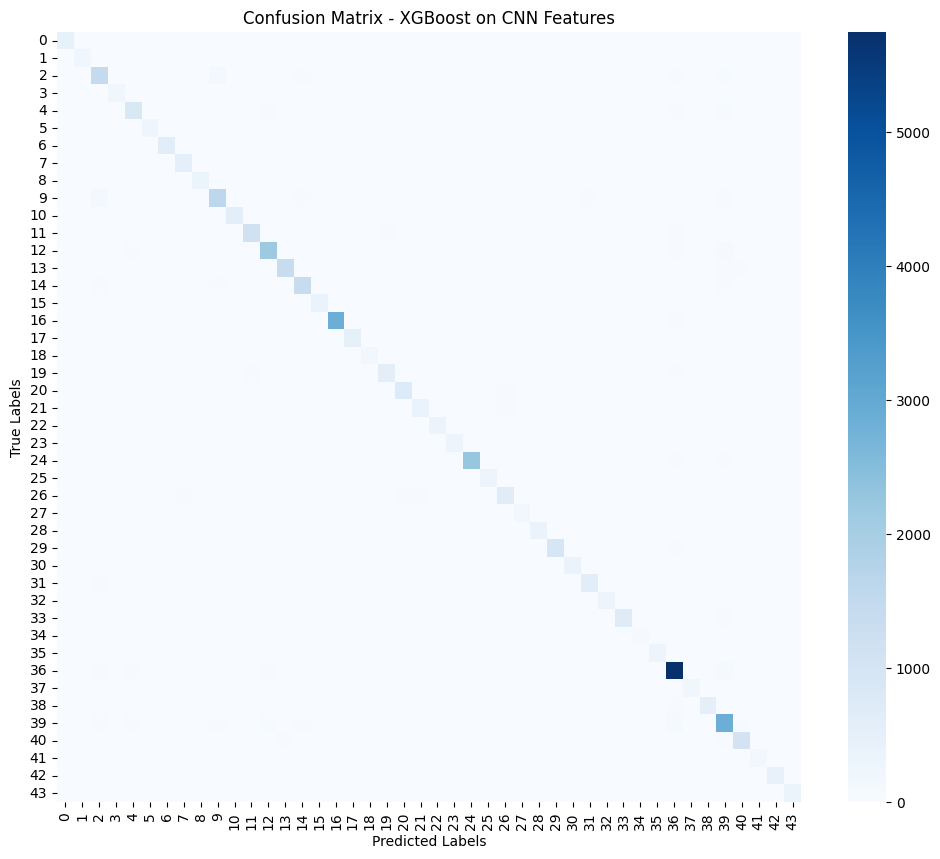

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost on CNN Features")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

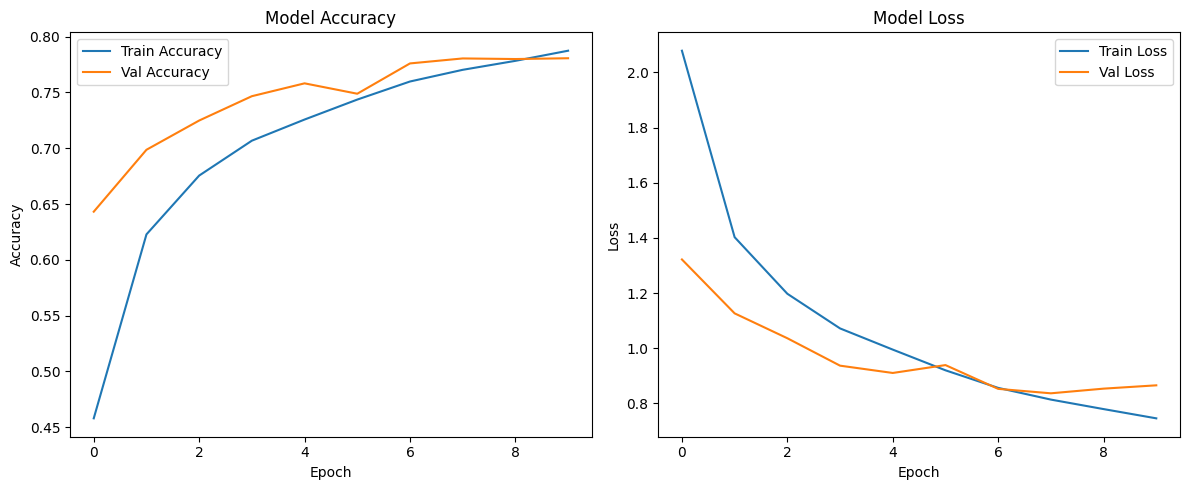

In [52]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()